In [38]:
%matplotlib inline


===========================================================================
Motor imagery decoding from EEG data using the Common Spatial Pattern (CSP)
===========================================================================

Decoding of motor imagery applied to EEG data decomposed using CSP.
Here the classifier is applied to features extracted on CSP filtered signals.

See http://en.wikipedia.org/wiki/Common_spatial_pattern and [1]. The EEGBCI
dataset is documented in [2]. The data set is available at PhysioNet [3].

References
----------

1. Zoltan J. Koles. The quantitative extraction and topographic mapping
   of the abnormal components in the clinical EEG. Electroencephalography
   and Clinical Neurophysiology, 79(6):440--447, December 1991.
2. Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N.,
   Wolpaw, J.R. (2004) BCI2000: A General-Purpose Brain-Computer Interface
   (BCI) System. IEEE TBME 51(6):1034-1043.
3. Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG,
   Mietus JE, Moody GB, Peng C-K, Stanley HE. (2000) PhysioBank,
   PhysioToolkit, and PhysioNet: Components of a New Research Resource for
   Complex Physiologic Signals. Circulation 101(23):e215-e220.

First let us read the list of filenames we want to read

In [3]:
from mne.datasets import eegbci

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

# The data will be downloaded (approximately 7.5 MB)
raw_fnames = eegbci.load_data(subject, runs)

**Q1** How many files does `raw_fnames` contain?

In [2]:
print(raw_fnames)
# your code here

[u'/home/mainak/Desktop/projects/examples/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R06.edf', u'/home/mainak/Desktop/projects/examples/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R10.edf', u'/home/mainak/Desktop/projects/examples/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R14.edf']


Let us read in the files now

In [41]:
from mne.io import concatenate_raws, read_raw_edf

raw_files = [read_raw_edf(f, preload=True) for f in raw_fnames]
raw = concatenate_raws(raw_files)

Extracting edf Parameters from /home/mainak/Desktop/projects/examples/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
Extracting edf Parameters from /home/mainak/Desktop/projects/examples/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.
Extracting edf Parameters from /home/mainak/Desktop/projects/examples/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Created Raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Ready.


In [42]:
import numpy as np
import matplotlib.pyplot as plt

from mne.channels import read_layout


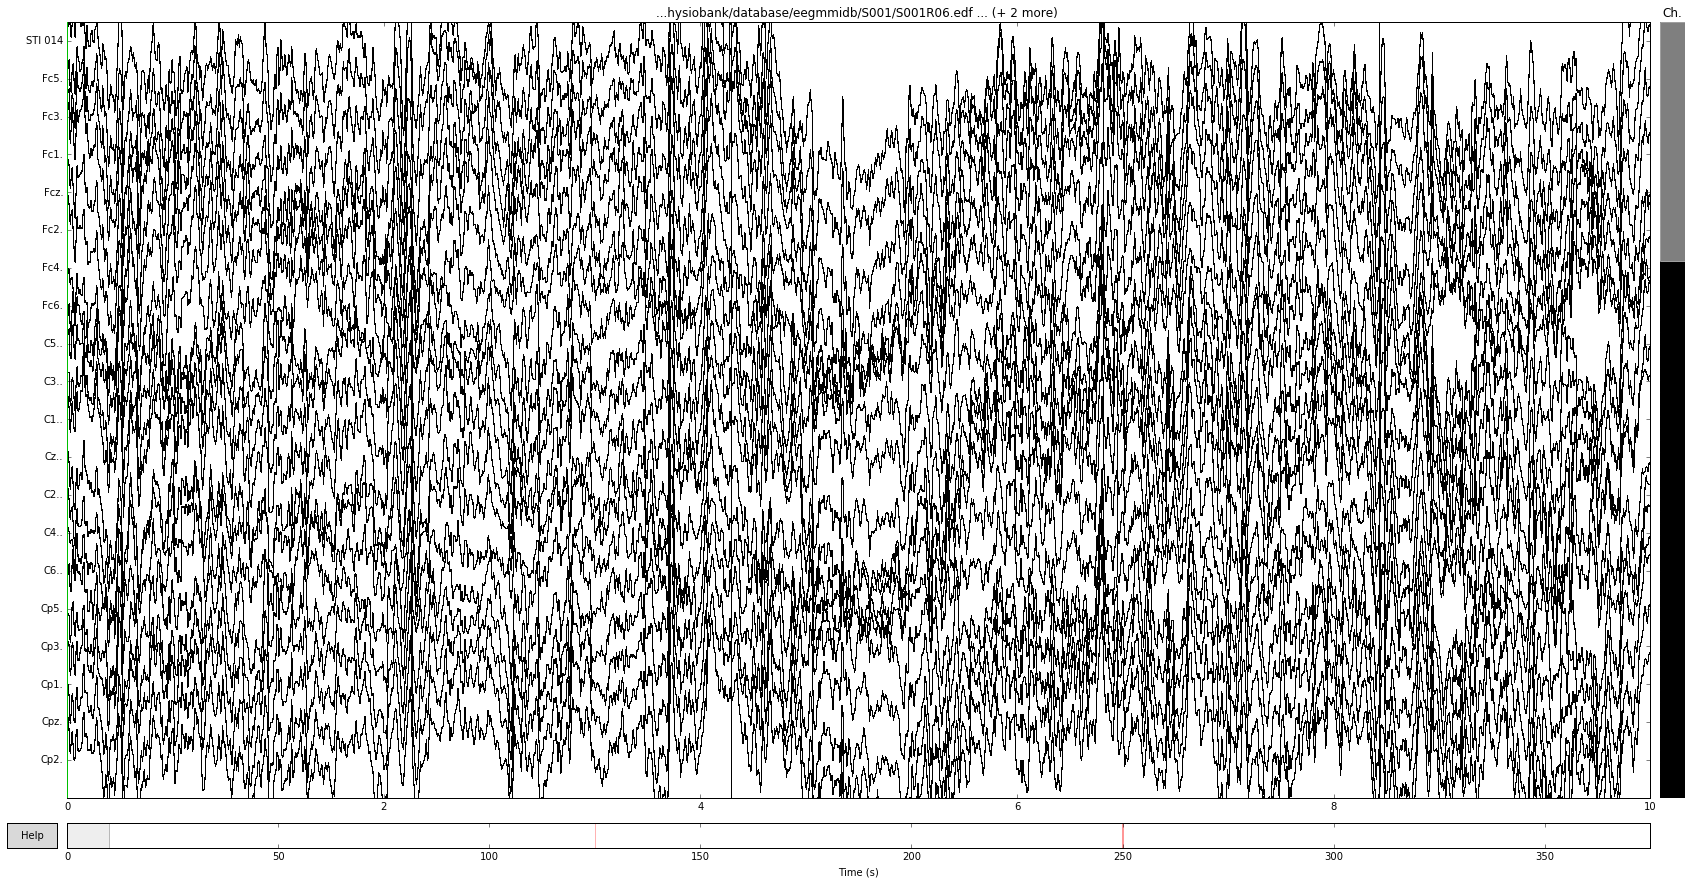

In [43]:
raw.plot();

In [44]:
# strip channel names of "." characters
print(raw.ch_names[:5])
raw.rename_channels(lambda x: x.strip('.'))
print(raw.ch_names[:5])

[u'Fc5.', u'Fc3.', u'Fc1.', u'Fcz.', u'Fc2.']
[u'Fc5', u'Fc3', u'Fc1', u'Fcz', u'Fc2']


Setting up band-pass filter from 7 - 30 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 528 samples (3.300 sec) selected


<ipython-input-45-650960265f98>:2: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  raw.filter(7., 30.)


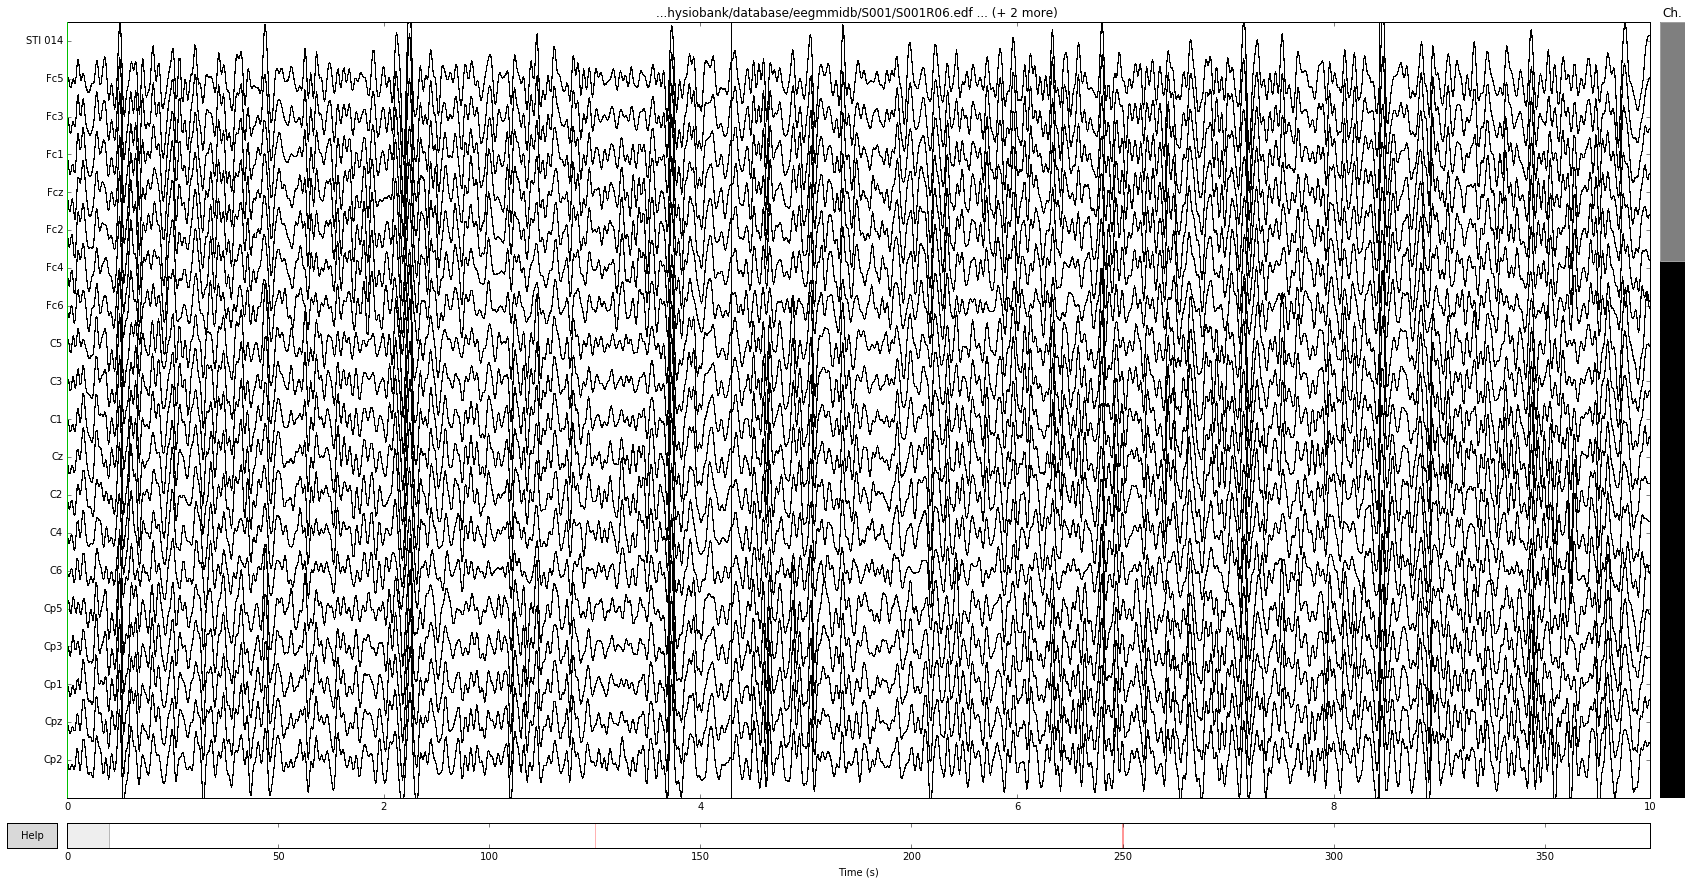

In [45]:
# Apply band-pass filter
raw.filter(7., 30.)
raw.plot();

The info attribute contains all the metadata

In [46]:
print(raw.info)

<Info | 16 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float | 1.0
    ch_names : list | Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, ...
    chs : list | 65 items (EEG: 64, MISC: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    events : list | 0 items
    highpass : float | 7.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 30.0 Hz
    meas_date : int | 1250093700
    nchan : int | 65
    projs : list | 0 items
    sfreq : float | 160.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplotter_layout : NoneType
>


Removing orphaned offset at the beginning of the file.
89 events found
Events id: [1 2 3]
event 1 missing from event_id will be ignored


<ipython-input-47-6e69050c8e9e>:5: RuntimeWarning: event 1 missing from event_id will be ignored
  plot_events(events, raw.info['sfreq'], event_id=event_id);


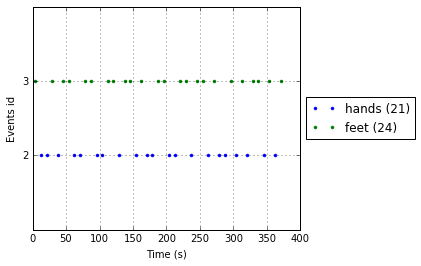

In [47]:
from mne import find_events
from mne.viz import plot_events

event_id = dict(hands=2, feet=3
events = find_events(raw, shortest_event=0, stim_channel='STI 014')
plot_events(events, raw.info['sfreq'], event_id=event_id);

In [48]:
from mne import Epochs, pick_types

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

tmin, tmax = -1., 4.
# Read epochs
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)

45 matching events found
0 projection items activated
Loading data for 45 events and 801 original time points ...
0 bad epochs dropped


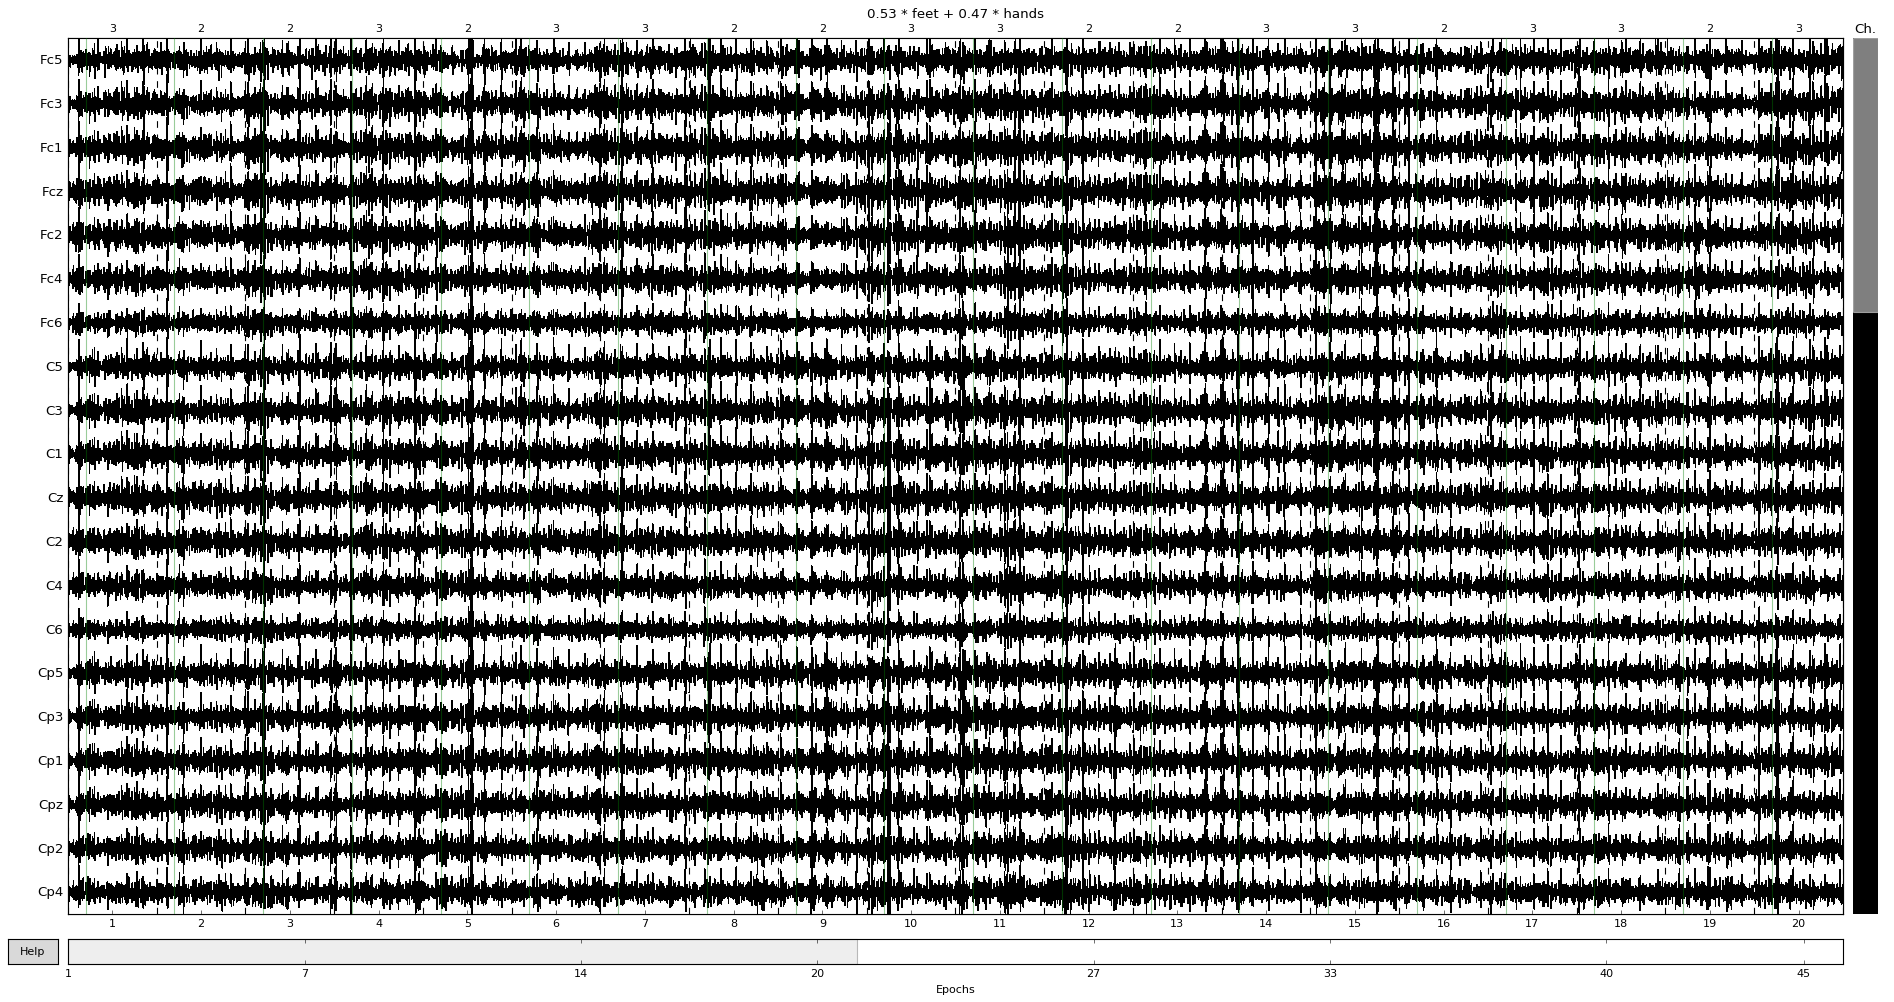

In [49]:
epochs.plot(scalings=dict(eeg=100e-6));

In [50]:
from sklearn.lda import LDA
from mne.decoding import CSP

# Assemble a classifier
lda = LDA()
csp = CSP(n_components=4, reg=None, log=True)

new_param defaults to True in 0.15, but will change to False in 0.16. Set it explicitly to avoid this warning.


<ipython-input-50-4259d2db8bb5>:5: DeprecationWarning: new_param defaults to True in 0.15, but will change to False in 0.16. Set it explicitly to avoid this warning.
  csp = CSP(n_components=4, reg=None, log=True)


Now, we can construct a Pipeline

In [56]:
from sklearn.pipeline import Pipeline
clf = Pipeline([('CSP', csp), ('LDA', lda)])

In [51]:
from sklearn.cross_validation import ShuffleSplit, cross_val_score

# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(len(labels), 10, test_size=0.2, random_state=42)
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)
print(scores)

[ 0.88888889  1.          1.          0.88888889  1.          1.          1.
  1.          0.77777778  0.88888889]


Classification with linear discrimant analysis



In [52]:
# (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1] - 2

epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

Classification accuracy: 0.944444 / Chance level: 0.533333


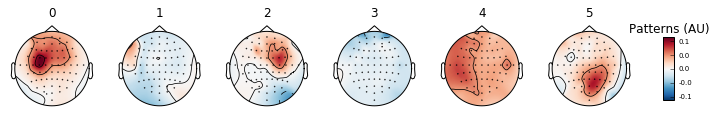

In [53]:
# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

evoked = epochs.average()
evoked.data = csp.patterns_.T
evoked.times = np.arange(evoked.data.shape[0])

layout = read_layout('EEG1005')
evoked.plot_topomap(times=[0, 1, 2, 3, 4, 5], ch_type='eeg', layout=layout,
                    scale_time=1, time_format='%i', scale=1,
                    unit='Patterns (AU)', size=1.5);

Look at performance over time



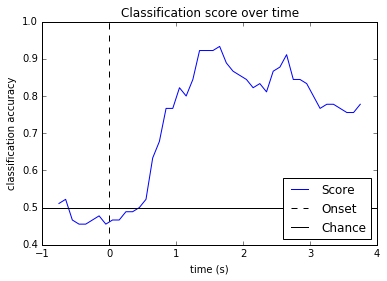

In [54]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()